## Imports and matplotlib config

Also sets rng seed for reproducible research

In [1]:
%pylab inline
figsize(10,10) # in the global namespace when inline backend is in use.

Populating the interactive namespace from numpy and matplotlib


In [8]:
import importlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import pickle
import scipy.stats as sps
import seaborn as sns
import seaborn.distributions as snsd


from algorithms.confidence_ss import confidenceMCMC 
from algorithms.confidence_ss import confidenceMCMCWithProxy
from algorithms.confidence_ss import confidenceMCMCWithProxyDroppedAlong
from algorithms.iss import iss_mcmc
from algorithms.utils import chain_error
from algorithms.vanillaMH import vanillaMH

In [3]:
sns.set(style="ticks");

plt.ioff() # turn off interactive plotting
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.titlesize'] = 22
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True
saveDirStr = "scaling_figs"
npr.seed(1)

# Smallest and largest exponents of 10 we test for sample size
small_exp = 3
large_exp = 6
exp_step= 0.5

EXPERIMENT_MAX_CHAIN_LENGTH = int(10**6)
REFERENCE_CHAIN_LENGTH = int(100*10**3)
EXPERIMENT_TIME_BUDGET = 60*5 # 5mins

# Scaling Experiment

### Generate parent sample
### Generate references across experiments using VanillaMH

In [5]:
try:
    print('Trying to load existing references')
    ref_chains = pickle.load(open('ref_chains.p', 'rb'))
    print('refchains loaded')
    experiment_samples = pickle.load(open('experiment_samples.p', 'rb'))
    print('samples loaded')
    experiment_MLEs = pickle.load(open('experiment_MLEs.p', 'rb'))
    print('MLEs loaded')
    sample_sizes_tested = [len(sample) for sample in experiment_samples]
    print(f'Testing N in {sample_sizes_tested}')
except FileNotFoundError:
    print('Cannot fine one or more existing references - regenerating.')
    sample_sizes_tested = [int(10**exp) for exp in np.arange(small_exp,large_exp+exp_step,exp_step)]
    max_samples = int(10**large_exp)
    # Here is where we make the model mis-specified if we wish to
    dataType = "Gaussian"
    if dataType == "Gaussian":
        parent_x = npr.randn(max_samples)
    elif dataType == "logNormal":
        parent_x = npr.lognormal(0,1,size=max_samples)
    elif dataType == "laplace":
        parent_x = npr.laplace(0,math.pow(0.5,0.5),size=max_samples)

    ref_chains = list()
    experiment_samples = list()
    experiment_MLEs = list()

    for i in sample_sizes_tested:
        # Watch out - python list and numpy array have append mean smth different
        experiment_samples.append(parent_x[:int(i)])

    for i, x in enumerate(experiment_samples):
        print(f'Generating reference with {sample_sizes_tested[i]:.2E} samples')
        realMean = np.mean(x)
        realStd = np.std(x)
        initial_theta = np.array([realMean,np.log(realStd)])
        experiment_MLEs.append(initial_theta)
        ref_chains.append(vanillaMH(initial_theta,x,time_budget=np.inf,chain_length=REFERENCE_CHAIN_LENGTH)[0])

    # To avoid losing these if we clear the notebook, pickle em
    print('Saving pickles to avoid having to recompute')
    pickle.dump(ref_chains,open('ref_chains.p', 'wb'))
    print('refchains saved')
    pickle.dump(experiment_samples,open('experiment_samples.p', 'wb'))
    print('experiment_samples saved')
    pickle.dump(experiment_MLEs,open('experiment_MLEs.p', 'wb'))
    print('experiment_MLEs saved')

Trying to load existing references
refchains loaded
samples loaded
MLEs loaded
Testing N in [1000, 3162, 10000, 31622, 100000, 316227, 1000000]


### Run experiments for varying N across all algorithms of interest

In [ ]:
# Sanity check of alg working
mh_results = vanillaMH(experiment_MLEs[0],experiment_samples[0])

In [ ]:
# Sanity check that error function is working as expected
chain_error(mh_results[0][:,0],np.array([0]*9999),show_hists=True)

In [6]:
def run_experiment(algorithm):
    mean_errors = []
    std_errors = []
    alg_steps_taken = []
    show_hists = False
    for i, x in enumerate(experiment_samples):
        ref_chain = ref_chains[i]
        print(f'Running experiment with N = {sample_sizes_tested[i]:.2E}, time budget {EXPERIMENT_TIME_BUDGET}, max chain length {EXPERIMENT_MAX_CHAIN_LENGTH}')
        initial_theta = experiment_MLEs[i]
        chain, _ , chain_steps_taken = algorithm(initial_theta, x, time_budget=EXPERIMENT_TIME_BUDGET, chain_length=EXPERIMENT_MAX_CHAIN_LENGTH)
        # I just wanna see the last histograms
        if i == len(experiment_samples)-1:
            show_hists = True
        # Think about using jsut one reference chain?
        mean_errors.append(chain_error(ref_chain[:,0],chain[:,0],show_hists=show_hists, title=f"Mean \n Ref Samples = {len(ref_chain[:,0])}, Alg Samples = {len(chain[:,0])}"))
        std_errors.append(chain_error(ref_chain[:,1],chain[:,1],show_hists=show_hists, title=f"log(Std) \n Ref Samples = {len(ref_chain[:,0])}, Alg Samples = {len(chain[:,0])}"))
        alg_steps_taken.append(chain_steps_taken)
    return (mean_errors, std_errors, alg_steps_taken)


Running experiment with N = 1.00E+03, time budget 300, max chain length 1000000
Iteration 0 Acceptance 1.0
Iteration 100000 Acceptance 0.4996250037499625
Iteration 200000 Acceptance 0.5072874635626822
Iteration 300000 Acceptance 0.5101916326945577
Iteration 400000 Acceptance 0.5115037212406969
Iteration 500000 Acceptance 0.5123029753940492
Iteration 600000 Acceptance 0.5128141453097578
Iteration 700000 Acceptance 0.5135792663153338
Iteration 800000 Acceptance 0.5137106078617402
Iteration 900000 Acceptance 0.513963873373474
Running experiment with N = 3.16E+03, time budget 300, max chain length 1000000
Iteration 0 Acceptance 1.0
Iteration 100000 Acceptance 0.4995950040499595
Iteration 200000 Acceptance 0.508082459587702
Iteration 300000 Acceptance 0.5101649661167796
Iteration 400000 Acceptance 0.5118837202906993
Iteration 500000 Acceptance 0.5123869752260496
Iteration 600000 Acceptance 0.5131108114819809
Iteration 700000 Acceptance 0.5134692664724765
Iteration 800000 Acceptance 0.513638

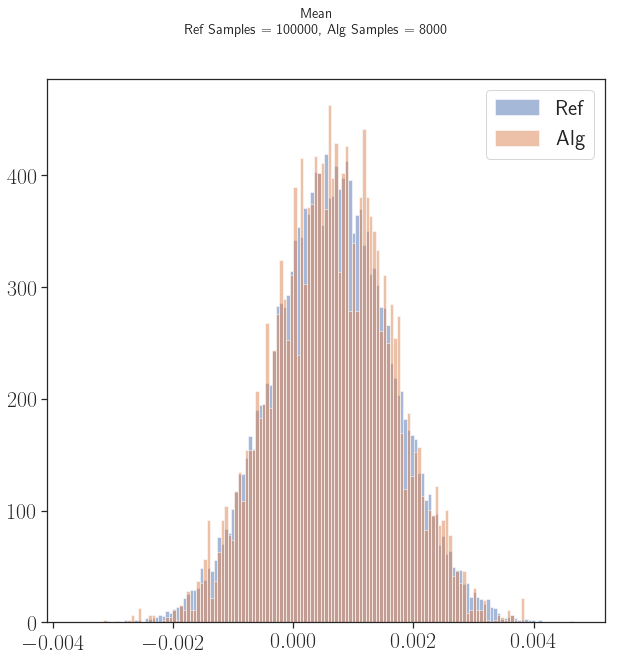

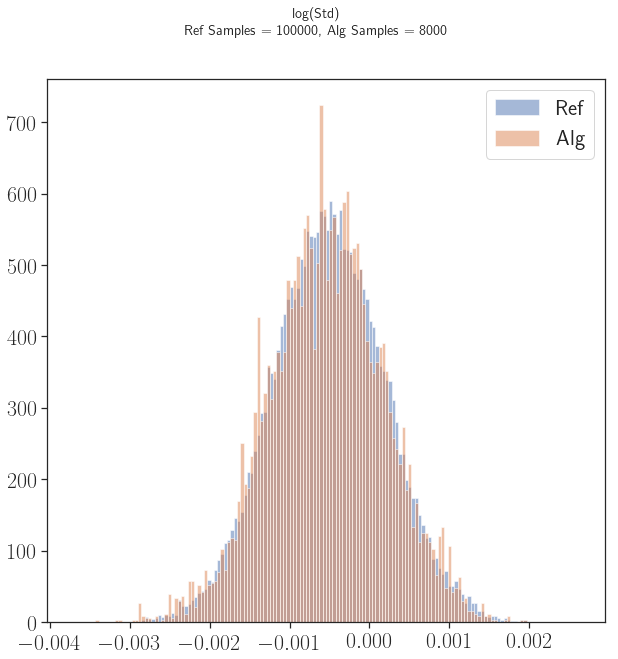

mh_results saved


In [7]:
mh_results = run_experiment(vanillaMH)
pickle.dump(mh_results,open('mh_results.p', 'wb'))
print('mh_results saved')

Running experiment with N = 1.00E+03, time budget 300, max chain length 1000000
Running ISS with n = 31, k = 5
Iteration 0 Theta Acceptance 0.0 Sample Acceptance 1.0
Iteration 100000 Theta Acceptance 0.7078029219707803 Sample Acceptance 0.0001799982000179998
Iteration 200000 Theta Acceptance 0.7088714556427218 Sample Acceptance 9.499952500237499e-05
Iteration 300000 Theta Acceptance 0.7081676394412019 Sample Acceptance 6.333312222292592e-05
Iteration 400000 Theta Acceptance 0.7078607303481741 Sample Acceptance 5.2499868750328125e-05
Iteration 500000 Theta Acceptance 0.7078145843708312 Sample Acceptance 4.3999912000176e-05
Iteration 600000 Theta Acceptance 0.7079088201519664 Sample Acceptance 3.999993333344445e-05
Iteration 700000 Theta Acceptance 0.7080161314055265 Sample Acceptance 3.5714234693950435e-05
Iteration 800000 Theta Acceptance 0.7083141146073567 Sample Acceptance 3.249995937505078e-05
Iteration 900000 Theta Acceptance 0.7083892129008745 Sample Acceptance 2.9999966666703703e

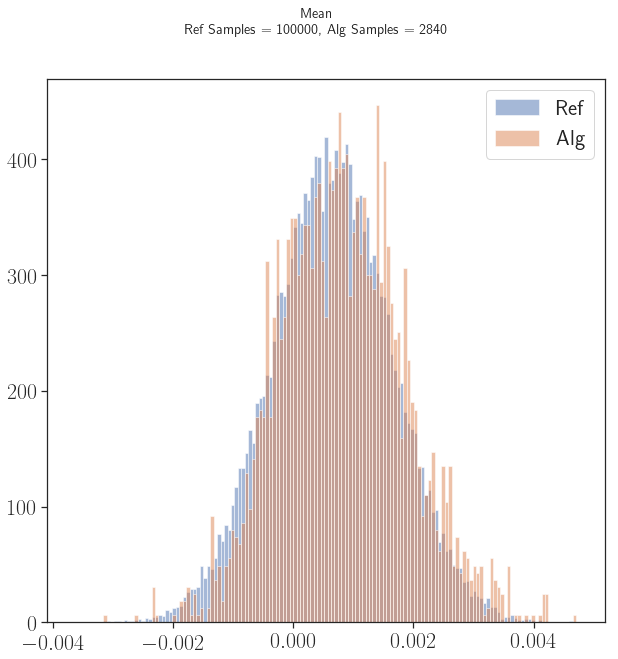

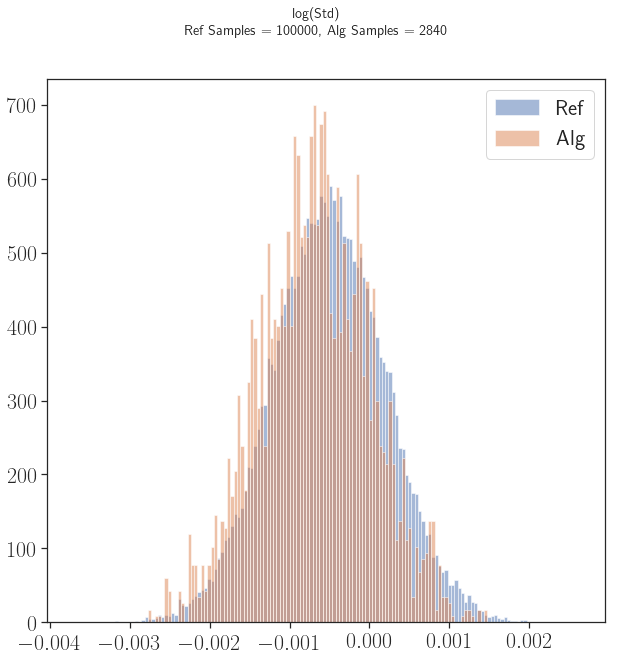

iss_results saved


In [9]:
iss_results = run_experiment(iss_mcmc)
pickle.dump(iss_results,open('iss_results.p', 'wb'))
print('iss_results saved')

In [ ]:
# cs_results = run_experiment(confidenceMCMC)

Running experiment with N = 1.00E+03, time budget 300, max chain length 1000000
MAP is [ 0.03881248 -0.01917861] Real values are 0.03881247615960185 -0.01917860542747583
[2*(-1 + 6*(mu - x)**2/sigma**2)/sigma**3, -6*(mu - x)/sigma**4, 2/sigma**3, 0]
Iteration 0 Acceptance 0.0 Avg. num samples 2000.0 Dist. to MAP 0.0 sigma/sqrt(n) 0.00023111628986691502 R/n 0.001610723895188254
Time budget consumed at chain step 21191, returning truncated result
Running experiment with N = 3.16E+03, time budget 300, max chain length 1000000
MAP is [ 0.02559909 -0.00345589] Real values are 0.025599088502711632 -0.0034558929352764014
[2*(-1 + 6*(mu - x)**2/sigma**2)/sigma**3, -6*(mu - x)/sigma**4, 2/sigma**3, 0]
Iteration 0 Acceptance 0.0 Avg. num samples 1422.0 Dist. to MAP 0.0 sigma/sqrt(n) 0.00010556871467880708 R/n 0.00014657524849859773
Time budget consumed at chain step 22697, returning truncated result
Running experiment with N = 1.00E+04, time budget 300, max chain length 1000000
MAP is [ 0.009772

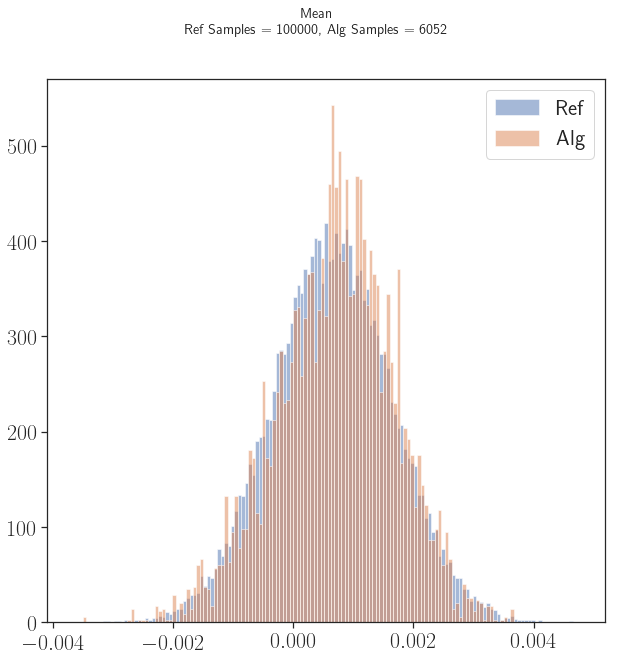

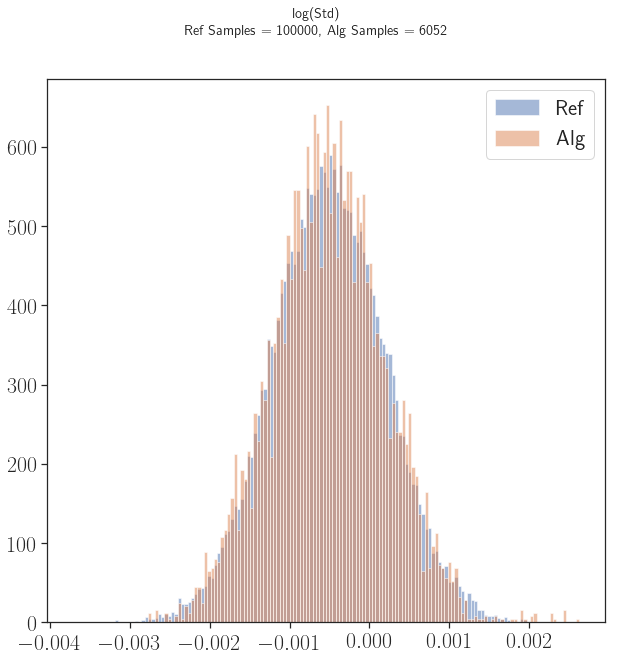

ics_results saved


In [10]:
ics_results = run_experiment(confidenceMCMCWithProxy)
pickle.dump(ics_results,open('ics_results.p', 'wb'))
print('ics_results saved')

In [ ]:
# ics_w_drop = run_experiment(confidenceMCMCWithProxyDroppedAlong)

In [24]:
# If we get results externally skip the sims and do this
mh_results = pickle.load(open('mh_results.p','rb'))
iss_results = pickle.load(open('iss_results.p','rb'))
ics_results = pickle.load(open('ics_results.p','rb'))


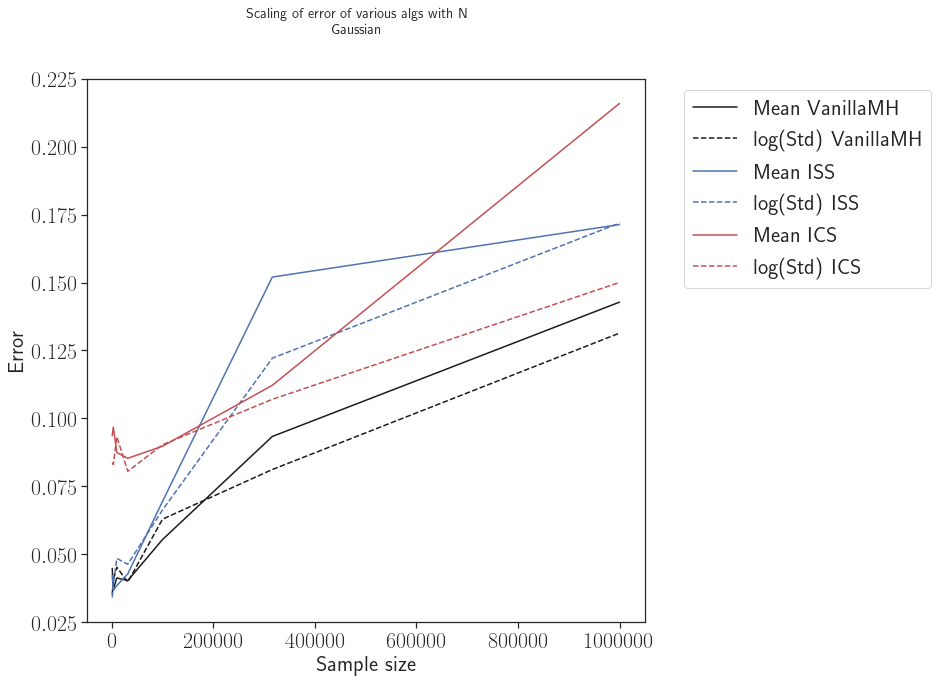

In [25]:
plt.clf()
plt.plot(
    sample_sizes_tested, mh_results[0], 'k',
    sample_sizes_tested, mh_results[1], '--k',
    sample_sizes_tested,iss_results[0], 'b',
    sample_sizes_tested,iss_results[1], '--b',
    sample_sizes_tested,ics_results[0], 'r',
    sample_sizes_tested,ics_results[1], '--r'
)
plt.suptitle(f'Scaling of error of various algs with N \n {dataType}')
plt.xlabel(f'Sample size')
plt.ylabel(f'Error')
plt.legend(('Mean VanillaMH', 
            'log(Std) VanillaMH',
            'Mean ISS',
            'log(Std) ISS',
            'Mean ICS',
            'log(Std) ICS'),
        bbox_to_anchor=(1.05, 1))
plt.show()

No handles with labels found to put in legend.


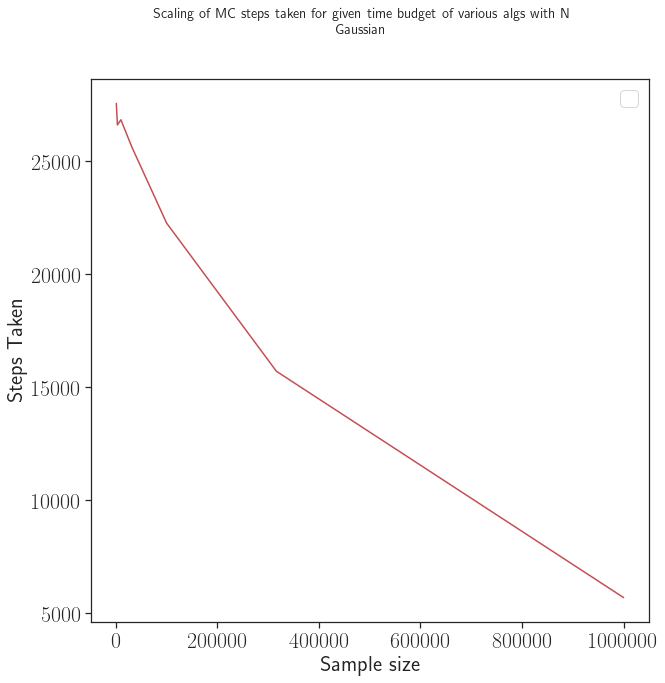

In [26]:
plt.clf()
plt.plot(
    sample_sizes_tested, mh_results[2], 'k',
    sample_sizes_tested,iss_results[2], 'b',
    sample_sizes_tested,ics_results[2], 'r',
)
# To peek at ICS itself
# plt.plot(
#     sample_sizes_tested,ics_results[2], 'r',
# )
# plt.legend()

plt.suptitle(f'Scaling of MC steps taken for given time budget of various algs with N \n {dataType}')
plt.xlabel(f'Sample size')
plt.ylabel(f'Steps Taken')
plt.legend(('VanillaMH', 
            'ISS',
            'ICS'),
        bbox_to_anchor=(1.05, 1))
plt.show()

# Critique: starting in MLE where we know mode already is